In [1]:
"""
Variational Autoencoder (VAE) on MNIST
======================================

This script implements a full VAE to generate new digit images
based on the MNIST dataset. Includes training, visualization, and generation.

Author: AI Assistant
Date: 2024
"""

'\nVariational Autoencoder (VAE) on MNIST\n======================================\n\nThis script implements a full VAE to generate new digit images\nbased on the MNIST dataset. Includes training, visualization, and generation.\n\nAuthor: AI Assistant\nDate: 2024\n'

=============================================================================
IMPORTS AND CONFIGURATION
=============================================================================

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Matplotlib configuration
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

In [4]:
# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [5]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

=============================================================================
MNIST DATASET PREPARATION
=============================================================================

In [6]:
def load_mnist():
    """
    Loads and prepares the MNIST dataset for training.
    
    Returns:
        train_loader, test_loader: DataLoaders for training and testing
    """
    print("Loading MNIST dataset...")
    
    # Transformations: convert to tensor only (ToTensor already normalizes to [0,1])
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
    # Load train and test datasets
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)
    
    # Create dataloaders
    batch_size = 128
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Training set: {len(train_dataset)} images")
    print(f"Test set: {len(test_dataset)} images")
    print(f"Batch size: {batch_size}")
    
    return train_loader, test_loader

In [7]:
def show_dataset_examples(train_loader):
    """
    Visualizes some images from the MNIST dataset.
    
    Args:
        train_loader: DataLoader for the training set
    """
    print("Showing dataset examples...")
    
    # Get a batch of data
    dataiter = iter(train_loader)
    images, labels = next(dataiter)
    
    # Show some images
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(10):
        row, col = i // 5, i % 5
        img = images[i].squeeze()
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].set_title(f'Digit: {labels[i].item()}')
        axes[row, col].axis('off')
    
    plt.suptitle('MNIST Dataset Examples', fontsize=16)
    plt.tight_layout()
    plt.show()

=============================================================================
VAE ARCHITECTURE
=============================================================================

In [8]:
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) for MNIST.
    
    The VAE consists of:
    1. Encoder: Maps images to latent distribution parameters (μ, σ)
    2. Reparameterization: Samples from latent space using the reparameterization trick
    3. Decoder: Reconstructs images from latent space
    """
    
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        """
        Initializes the VAE.
        
        Args:
            input_dim: Input dimension (28x28 = 784 for MNIST)
            hidden_dim: Hidden layer dimension
            latent_dim: Latent space dimension
        """
        super(VAE, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # Encoder: Image -> Latent distribution parameters
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Layers to produce μ and log(σ²) for latent space
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder: Latent space -> Reconstructed image
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Output between 0 and 1
        )
    
    def encode(self, x):
        """
        Encodes input x into latent distribution parameters.
        
        Args:
            x: Input tensor (batch_size, input_dim)
            
        Returns:
            mu, logvar: Latent distribution parameters
        """
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparametrize(self, mu, logvar):
        """
        Implements the reparameterization trick for differentiable sampling.
        
        Args:
            mu: Mean of latent distribution
            logvar: Log variance of latent distribution
            
        Returns:
            z: Latent space sample
        """
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z = mu + eps * std
        else:
            z = mu
        return z
    
    def decode(self, z):
        """
        Decodes latent vector z into a reconstructed image.
        
        Args:
            z: Latent space vector
            
        Returns:
            x_recon: Reconstructed image
        """
        # Decode and clamp to ensure output is in [0,1] range
        x_recon = self.decoder(z)
        return torch.clamp(x_recon, 0, 1)
    
    def forward(self, x):
        """
        Full forward pass of the VAE.
        
        Args:
            x: Input tensor (batch_size, input_dim)
            
        Returns:
            x_recon, mu, logvar: Reconstructed image and latent parameters
        """
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

=============================================================================
VAE LOSS FUNCTION
=============================================================================

In [9]:
def vae_loss(x_recon, x, mu, logvar, beta=1.0):
    """
    Computes the VAE loss function.
    
    Total loss: L = L_reconstruction + β * L_KL
    
    Args:
        x_recon: Reconstructed image
        x: Original image
        mu: Latent mean
        logvar: Latent log variance
        beta: Weight for KL term (β-VAE)
        
    Returns:
        loss: Total loss
        recon_loss: Reconstruction loss
        kl_loss: KL loss
    """
    # Reconstruction loss (Binary Cross Entropy)
    # Clamp reconstructed images to [0,1] range to avoid BCE errors
    x_recon_clamped = torch.clamp(x_recon, 0, 1)
    recon_loss = F.binary_cross_entropy(x_recon_clamped, x, reduction='sum')
    
    # KL loss: D_KL(N(μ, σ²) || N(0, I))
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    total_loss = recon_loss + beta * kl_loss
    return total_loss, recon_loss, kl_loss

=============================================================================
VAE TRAINING
=============================================================================

In [10]:
def train_vae(model, train_loader, test_loader, num_epochs=50, lr=1e-3):
    """
    Trains the VAE model.
    
    Args:
        model: VAE model
        train_loader: Training DataLoader
        test_loader: Test DataLoader
        num_epochs: Number of training epochs
        lr: Learning rate
        
    Returns:
        train_losses: List of training losses per epoch
        test_losses: List of test losses per epoch
    """
    print(f"Starting VAE training for {num_epochs} epochs...")
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        total_recon_loss = 0
        total_kl_loss = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for batch_idx, (data, _) in enumerate(pbar):
            data = data.to(device)
            data = data.view(-1, 784)
            
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss, recon_loss, kl_loss = vae_loss(recon_batch, data, mu, logvar)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
            
            pbar.set_postfix({
                'Loss': f'{loss.item():.2f}',
                'Recon': f'{recon_loss.item():.2f}',
                'KL': f'{kl_loss.item():.2f}'
            })
        
        # Calcular pérdidas promedio
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        avg_recon_loss = total_recon_loss / len(train_loader.dataset)
        avg_kl_loss = total_kl_loss / len(train_loader.dataset)
        
        train_losses.append(avg_train_loss)
        
        # Evaluación en conjunto de prueba
        model.eval()
        total_test_loss = 0
        
        with torch.no_grad():
            for data, _ in test_loader:
                data = data.to(device)
                data = data.view(-1, 784)
                recon_batch, mu, logvar = model(data)
                loss, _, _ = vae_loss(recon_batch, data, mu, logvar)
                total_test_loss += loss.item()
        
        avg_test_loss = total_test_loss / len(test_loader.dataset)
        test_losses.append(avg_test_loss)
        
        print(f'Época {epoch+1}: Train Loss: {avg_train_loss:.4f}, '
              f'Recon: {avg_recon_loss:.4f}, KL: {avg_kl_loss:.4f}, '
              f'Test Loss: {avg_test_loss:.4f}')
    
    print("Entrenamiento completado!")
    return train_losses, test_losses

=============================================================================
VISUALIZACIÓN Y EVALUACIÓN
=============================================================================

In [11]:
def visualizar_reconstrucciones(model, test_loader, num_examples=10):
    """
    Visualiza las reconstrucciones del VAE.
    
    Args:
        model: Modelo VAE entrenado
        test_loader: DataLoader de prueba
        num_examples: Número de ejemplos a mostrar
    """
    print("Visualizando reconstrucciones...")
    
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    
    # Tomar solo los primeros num_examples
    images = images[:num_examples].to(device)
    labels = labels[:num_examples]
    
    # Aplanar imágenes
    images_flat = images.view(-1, 784)
    
    with torch.no_grad():
        # Generar reconstrucciones
        recon_images, _, _ = model(images_flat)
        recon_images = recon_images.view(-1, 28, 28)
    
    # Visualizar originales vs reconstrucciones
    fig, axes = plt.subplots(2, num_examples, figsize=(2*num_examples, 4))
    
    for i in range(num_examples):
        # Imagen original
        axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
        axes[0, i].set_title(f'Original: {labels[i].item()}')
        axes[0, i].axis('off')
        
        # Imagen reconstruida
        axes[1, i].imshow(recon_images[i].cpu().squeeze(), cmap='gray')
        axes[1, i].set_title(f'Reconstruida')
        axes[1, i].axis('off')
    
    plt.suptitle('Originales vs Reconstrucciones del VAE', fontsize=16)
    plt.tight_layout()
    plt.show()

In [12]:
def visualizar_espacio_latente(model, test_loader):
    """
    Visualiza el espacio latente del VAE usando t-SNE o PCA.
    
    Args:
        model: Modelo VAE entrenado
        test_loader: DataLoader de prueba
    """
    print("Visualizando espacio latente...")
    
    model.eval()
    latents = []
    labels = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            data = data.view(-1, 784)
            mu, _ = model.encode(data)
            latents.append(mu.cpu())
            labels.append(target)
    
    # Concatenar todos los vectores latentes
    latents = torch.cat(latents, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    
    # Visualizar las primeras 2 dimensiones del espacio latente
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, label='Dígito')
    plt.xlabel('Dimensión Latente 1')
    plt.ylabel('Dimensión Latente 2')
    plt.title('Visualización del Espacio Latente del VAE (Primeras 2 Dimensiones)')
    plt.grid(True, alpha=0.3)
    plt.show()

=============================================================================
GENERACIÓN DE NUEVAS IMÁGENES
=============================================================================

In [13]:
def generar_imagenes(model, num_images=16):
    """
    Genera nuevas imágenes muestreando del espacio latente.
    
    Args:
        model: Modelo VAE entrenado
        num_images: Número de imágenes a generar
    """
    print(f"Generando {num_images} nuevas imágenes...")
    
    model.eval()
    
    with torch.no_grad():
        # Muestrear del espacio latente (distribución normal estándar)
        z = torch.randn(num_images, model.latent_dim).to(device)
        
        # Decodificar para generar imágenes
        generated_images = model.decode(z)
        generated_images = generated_images.view(-1, 28, 28)
    
    # Visualizar imágenes generadas
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    for i in range(num_images):
        row, col = i // 4, i % 4
        axes[row, col].imshow(generated_images[i].cpu().squeeze(), cmap='gray')
        axes[row, col].set_title(f'Imagen {i+1}')
        axes[row, col].axis('off')
    
    plt.suptitle('Imágenes Generadas por el VAE', fontsize=16)
    plt.tight_layout()
    plt.show()

In [14]:
def generar_imagenes_controladas(model, num_steps=10):
    """
    Genera imágenes interpolando en el espacio latente para mostrar continuidad.
    
    Args:
        model: Modelo VAE entrenado
        num_steps: Número de pasos de interpolación
    """
    print("Generando interpolación en el espacio latente...")
    
    model.eval()
    
    with torch.no_grad():
        # Crear dos puntos en el espacio latente
        z1 = torch.randn(1, model.latent_dim).to(device)
        z2 = torch.randn(1, model.latent_dim).to(device)
        
        # Interpolar entre los dos puntos
        alphas = torch.linspace(0, 1, num_steps).to(device)
        interpolated_images = []
        
        for alpha in alphas:
            z_interp = alpha * z1 + (1 - alpha) * z2
            img = model.decode(z_interp)
            interpolated_images.append(img.view(28, 28))
    
    # Visualizar interpolación
    fig, axes = plt.subplots(1, num_steps, figsize=(2*num_steps, 2))
    for i, img in enumerate(interpolated_images):
        axes[i].imshow(img.cpu().squeeze(), cmap='gray')
        axes[i].set_title(f'α={i/(num_steps-1):.1f}')
        axes[i].axis('off')
    
    plt.suptitle('Interpolación en el Espacio Latente', fontsize=16)
    plt.tight_layout()
    plt.show()

=============================================================================
FUNCIÓN PRINCIPAL
=============================================================================

In [15]:
def main():
    """
    Función principal que ejecuta todo el pipeline del VAE.
    """
    print("=" * 60)
    print("AUTOENCODER VARIACIONAL (VAE) EN MNIST")
    print("=" * 60)
    
    # 1. Cargar dataset
    train_loader, test_loader = load_mnist()
    
    # 2. Visualizar dataset
    show_dataset_examples(train_loader)
    
    # 3. Crear modelo VAE
    print("\nCreando modelo VAE...")
    model = VAE(input_dim=784, hidden_dim=400, latent_dim=20).to(device)
    print(f"Modelo creado con {sum(p.numel() for p in model.parameters()):,} parámetros")
    
    # 4. Entrenar modelo
    train_losses, test_losses = train_vae(model, train_loader, test_loader, num_epochs=30)
    
    # 5. Visualizar pérdidas de entrenamiento
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Entrenamiento')
    plt.plot(test_losses, label='Prueba')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.title('Evolución de la Pérdida durante el Entrenamiento')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Entrenamiento')
    plt.plot(test_losses, label='Prueba')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.title('Evolución de la Pérdida (Escala Log)')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 6. Visualizar reconstrucciones
    visualizar_reconstrucciones(model, test_loader)
    
    # 7. Visualizar espacio latente
    visualizar_espacio_latente(model, test_loader)
    
    # 8. Generar nuevas imágenes
    generar_imagenes(model, num_images=16)
    
    # 9. Generar interpolación
    generar_imagenes_controladas(model, num_steps=10)
    
    print("\n" + "=" * 60)
    print("¡EXPERIMENTO COMPLETADO EXITOSAMENTE!")
    print("=" * 60)
    print("\nResumen de lo aprendido:")
    print("1. El VAE aprendió a comprimir imágenes de MNIST en un espacio latente de 20 dimensiones")
    print("2. Puede reconstruir imágenes con buena calidad")
    print("3. El espacio latente es continuo y permite generar nuevas imágenes")
    print("4. La interpolación en el espacio latente produce transiciones suaves")
    print("\nAplicaciones potenciales:")
    print("- Generación de imágenes de dígitos")
    print("- Compresión de datos")
    print("- Análisis de representaciones latentes")
    print("- Transferencia de estilo en imágenes")

AUTOENCODER VARIACIONAL (VAE) EN MNIST
Loading MNIST dataset...
Training set: 60000 images
Test set: 10000 images
Batch size: 128
Showing dataset examples...


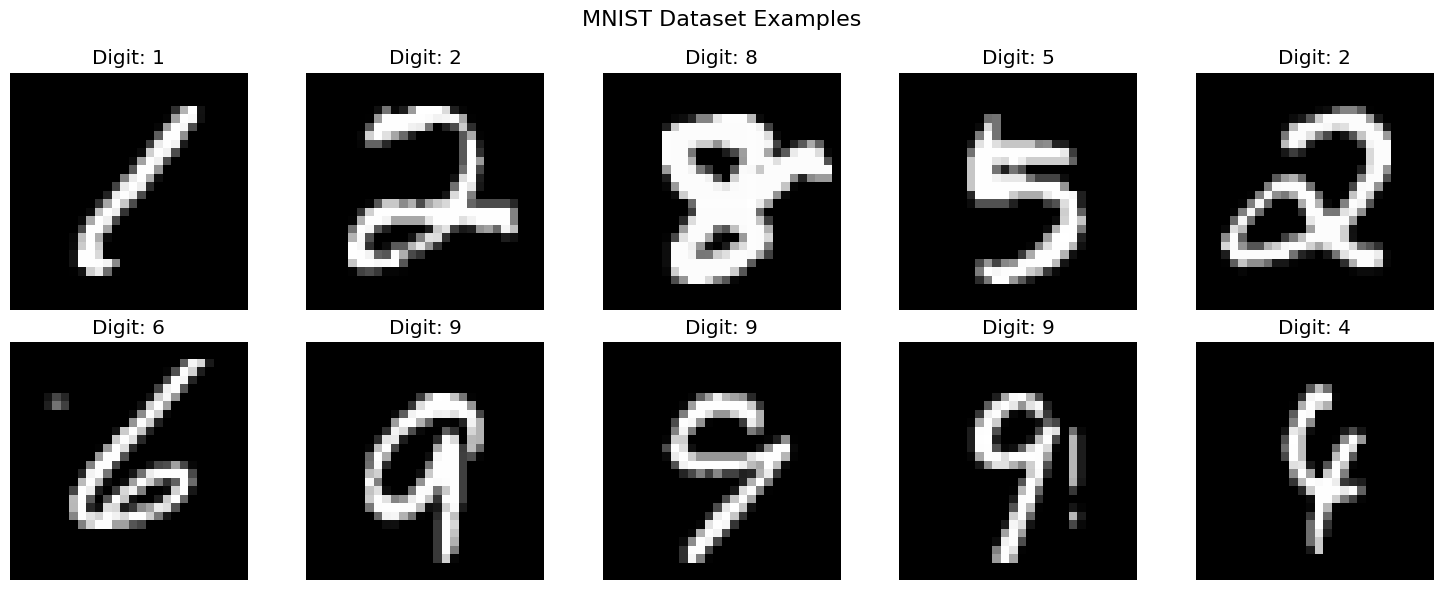


Creando modelo VAE...
Modelo creado con 973,624 parámetros
Starting VAE training for 30 epochs...


Epoch 1/30: 100%|██████████| 469/469 [00:05<00:00, 85.45it/s, Loss=13704.73, Recon=12351.08, KL=1353.64]


Época 1: Train Loss: 178.0715, Recon: 170.9444, KL: 7.1272, Test Loss: 135.6726


Epoch 2/30: 100%|██████████| 469/469 [00:05<00:00, 91.08it/s, Loss=11698.49, Recon=10213.09, KL=1485.41]


Época 2: Train Loss: 130.4419, Recon: 116.2735, KL: 14.1684, Test Loss: 118.0195


Epoch 3/30: 100%|██████████| 469/469 [00:05<00:00, 88.87it/s, Loss=11414.51, Recon=9857.83, KL=1556.68] 


Época 3: Train Loss: 118.7675, Recon: 102.3833, KL: 16.3841, Test Loss: 109.0652


Epoch 4/30: 100%|██████████| 469/469 [00:05<00:00, 91.22it/s, Loss=11014.55, Recon=9313.07, KL=1701.49] 


Época 4: Train Loss: 113.1468, Recon: 95.6692, KL: 17.4776, Test Loss: 104.5494


Epoch 5/30: 100%|██████████| 469/469 [00:05<00:00, 89.20it/s, Loss=10065.85, Recon=8343.08, KL=1722.77] 


Época 5: Train Loss: 110.0924, Recon: 92.0496, KL: 18.0428, Test Loss: 102.9010


Epoch 6/30: 100%|██████████| 469/469 [00:05<00:00, 90.84it/s, Loss=9961.48, Recon=8126.73, KL=1834.75]  


Época 6: Train Loss: 108.1754, Recon: 89.7907, KL: 18.3848, Test Loss: 101.6298


Epoch 7/30: 100%|██████████| 469/469 [00:05<00:00, 88.19it/s, Loss=10564.18, Recon=8758.40, KL=1805.77] 


Época 7: Train Loss: 106.7345, Recon: 88.1193, KL: 18.6151, Test Loss: 100.8849


Epoch 8/30: 100%|██████████| 469/469 [00:05<00:00, 90.09it/s, Loss=9841.80, Recon=8087.65, KL=1754.15]  


Época 8: Train Loss: 105.5955, Recon: 86.7388, KL: 18.8568, Test Loss: 99.8167


Epoch 9/30: 100%|██████████| 469/469 [00:05<00:00, 90.98it/s, Loss=10029.21, Recon=8166.62, KL=1862.59] 


Época 9: Train Loss: 104.6369, Recon: 85.4859, KL: 19.1510, Test Loss: 98.4306


Epoch 10/30: 100%|██████████| 469/469 [00:05<00:00, 90.41it/s, Loss=10284.00, Recon=8405.71, KL=1878.30] 


Época 10: Train Loss: 103.7530, Recon: 84.3988, KL: 19.3542, Test Loss: 97.6038


Epoch 11/30: 100%|██████████| 469/469 [00:05<00:00, 89.30it/s, Loss=9745.01, Recon=7868.19, KL=1876.82]  


Época 11: Train Loss: 103.0858, Recon: 83.5502, KL: 19.5356, Test Loss: 97.2372


Epoch 12/30: 100%|██████████| 469/469 [00:05<00:00, 89.98it/s, Loss=9752.83, Recon=7836.54, KL=1916.29]  


Época 12: Train Loss: 102.4997, Recon: 82.8259, KL: 19.6739, Test Loss: 97.2058


Epoch 13/30: 100%|██████████| 469/469 [00:05<00:00, 89.38it/s, Loss=9667.71, Recon=7837.19, KL=1830.52]  


Época 13: Train Loss: 101.9966, Recon: 82.2218, KL: 19.7748, Test Loss: 96.3996


Epoch 14/30: 100%|██████████| 469/469 [00:05<00:00, 90.59it/s, Loss=9619.07, Recon=7739.27, KL=1879.80]  


Época 14: Train Loss: 101.6114, Recon: 81.7489, KL: 19.8624, Test Loss: 95.9116


Epoch 15/30: 100%|██████████| 469/469 [00:05<00:00, 89.77it/s, Loss=9652.91, Recon=7778.54, KL=1874.37]  


Época 15: Train Loss: 101.2738, Recon: 81.3498, KL: 19.9240, Test Loss: 95.5349


Epoch 16/30: 100%|██████████| 469/469 [00:05<00:00, 90.39it/s, Loss=10171.50, Recon=8241.71, KL=1929.79] 


Época 16: Train Loss: 100.9255, Recon: 80.9431, KL: 19.9824, Test Loss: 95.5915


Epoch 17/30: 100%|██████████| 469/469 [00:05<00:00, 90.51it/s, Loss=9917.90, Recon=7952.36, KL=1965.54]  


Época 17: Train Loss: 100.5755, Recon: 80.5328, KL: 20.0427, Test Loss: 95.6116


Epoch 18/30: 100%|██████████| 469/469 [00:05<00:00, 81.37it/s, Loss=9977.38, Recon=7954.76, KL=2022.62]  


Época 18: Train Loss: 100.3721, Recon: 80.2909, KL: 20.0812, Test Loss: 95.2807


Epoch 19/30: 100%|██████████| 469/469 [00:05<00:00, 91.08it/s, Loss=9880.19, Recon=7904.77, KL=1975.42]  


Época 19: Train Loss: 100.1244, Recon: 80.0087, KL: 20.1157, Test Loss: 95.1536


Epoch 20/30: 100%|██████████| 469/469 [00:05<00:00, 90.88it/s, Loss=9749.91, Recon=7818.22, KL=1931.69]  


Época 20: Train Loss: 99.8600, Recon: 79.7018, KL: 20.1582, Test Loss: 94.8403


Epoch 21/30: 100%|██████████| 469/469 [00:05<00:00, 89.34it/s, Loss=9304.42, Recon=7350.76, KL=1953.66]  


Época 21: Train Loss: 99.7384, Recon: 79.5271, KL: 20.2113, Test Loss: 95.2414


Epoch 22/30: 100%|██████████| 469/469 [00:05<00:00, 88.59it/s, Loss=9309.63, Recon=7423.87, KL=1885.76]  


Época 22: Train Loss: 99.5631, Recon: 79.3352, KL: 20.2279, Test Loss: 94.4103


Epoch 23/30: 100%|██████████| 469/469 [00:05<00:00, 90.89it/s, Loss=9478.51, Recon=7570.39, KL=1908.12]  


Época 23: Train Loss: 99.3935, Recon: 79.1167, KL: 20.2768, Test Loss: 94.5407


Epoch 24/30: 100%|██████████| 469/469 [00:05<00:00, 89.68it/s, Loss=9670.90, Recon=7680.13, KL=1990.77]  


Época 24: Train Loss: 99.1786, Recon: 78.8931, KL: 20.2855, Test Loss: 94.5442


Epoch 25/30: 100%|██████████| 469/469 [00:05<00:00, 90.41it/s, Loss=9286.69, Recon=7278.96, KL=2007.73]  


Época 25: Train Loss: 99.0727, Recon: 78.7413, KL: 20.3313, Test Loss: 94.9750


Epoch 26/30: 100%|██████████| 469/469 [00:05<00:00, 81.35it/s, Loss=9461.24, Recon=7454.22, KL=2007.03]  


Época 26: Train Loss: 98.9112, Recon: 78.5905, KL: 20.3207, Test Loss: 95.3644


Epoch 27/30: 100%|██████████| 469/469 [00:05<00:00, 89.67it/s, Loss=9611.84, Recon=7626.30, KL=1985.54]   


Época 27: Train Loss: 98.8337, Recon: 78.4854, KL: 20.3483, Test Loss: 94.6387


Epoch 28/30: 100%|██████████| 469/469 [00:05<00:00, 92.19it/s, Loss=9270.00, Recon=7359.90, KL=1910.10]   


Época 28: Train Loss: 98.6492, Recon: 78.2865, KL: 20.3627, Test Loss: 94.0408


Epoch 29/30: 100%|██████████| 469/469 [00:05<00:00, 91.34it/s, Loss=9770.82, Recon=7750.56, KL=2020.26]   


Época 29: Train Loss: 98.5570, Recon: 78.1710, KL: 20.3859, Test Loss: 94.2510


Epoch 30/30: 100%|██████████| 469/469 [00:04<00:00, 97.55it/s, Loss=9585.79, Recon=7550.48, KL=2035.30]   


Época 30: Train Loss: 98.4829, Recon: 78.0620, KL: 20.4209, Test Loss: 94.8001
Entrenamiento completado!


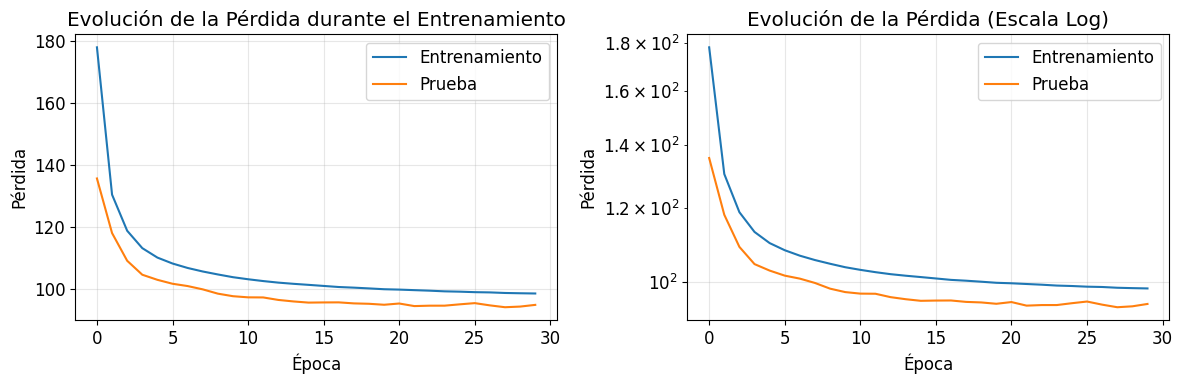

Visualizando reconstrucciones...


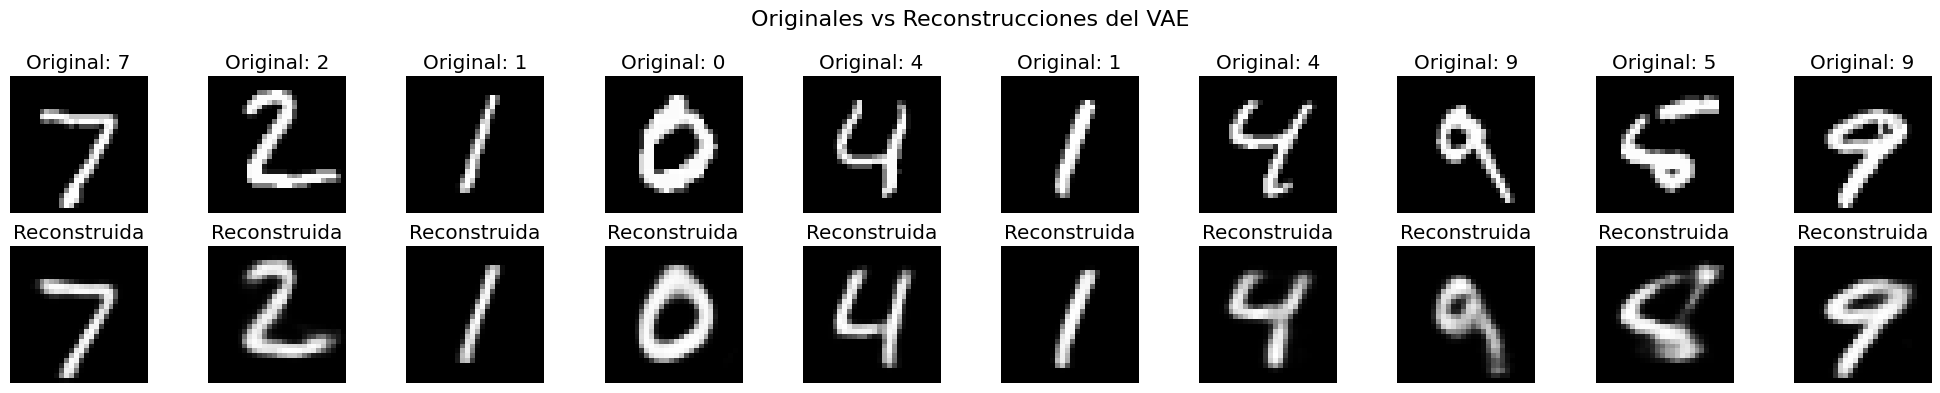

Visualizando espacio latente...


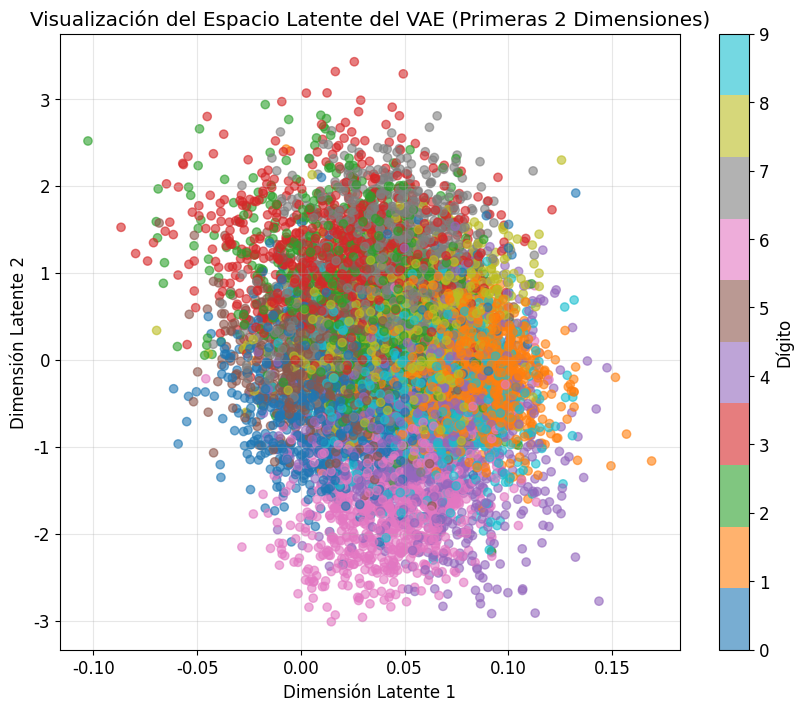

Generando 16 nuevas imágenes...


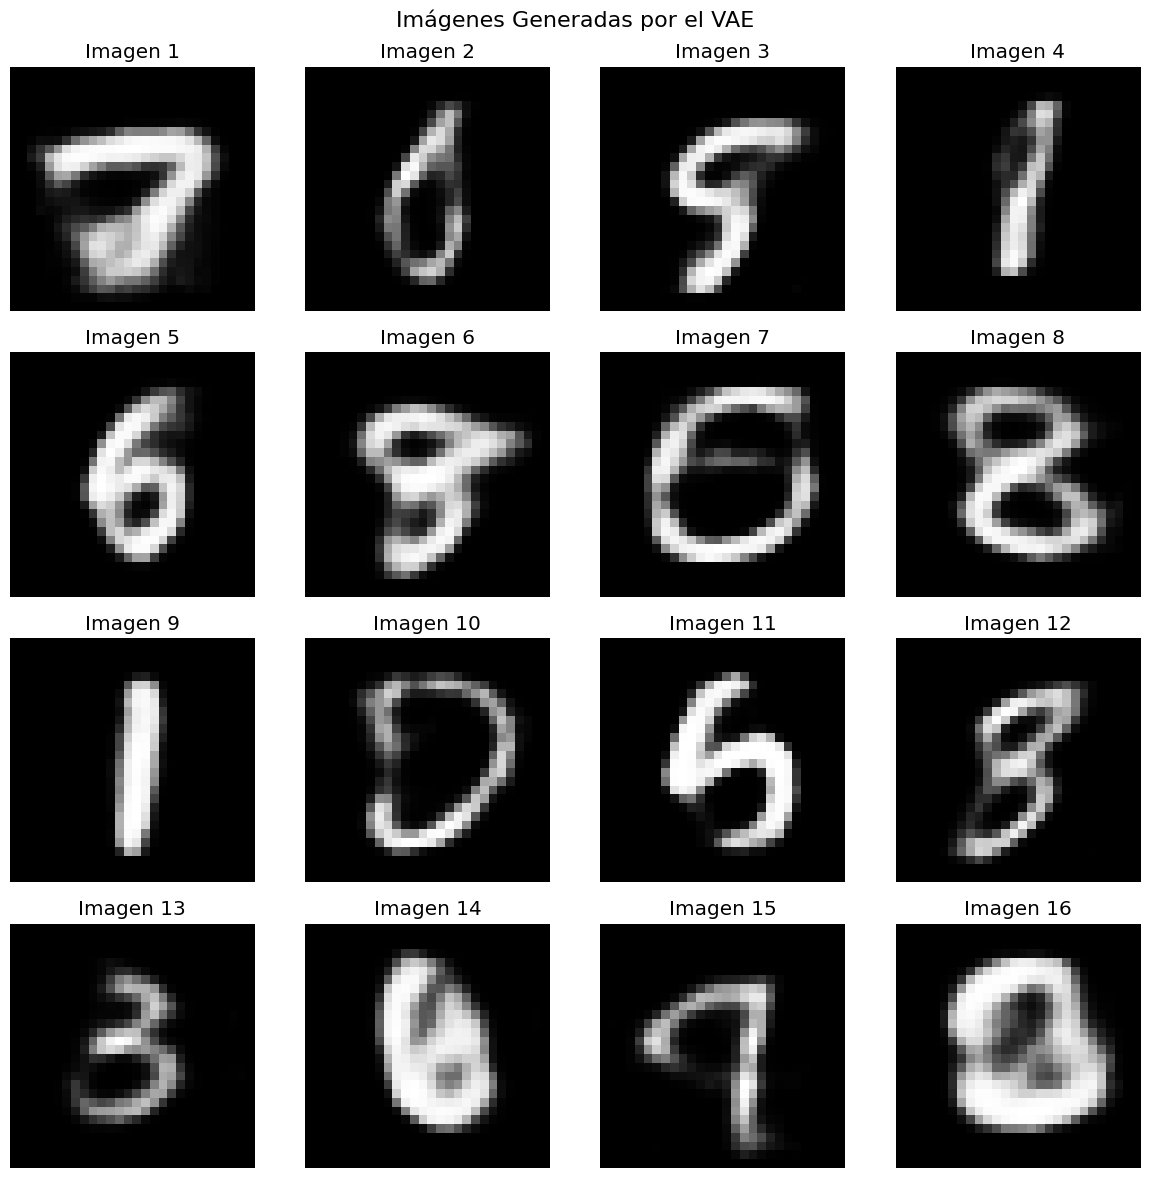

Generando interpolación en el espacio latente...


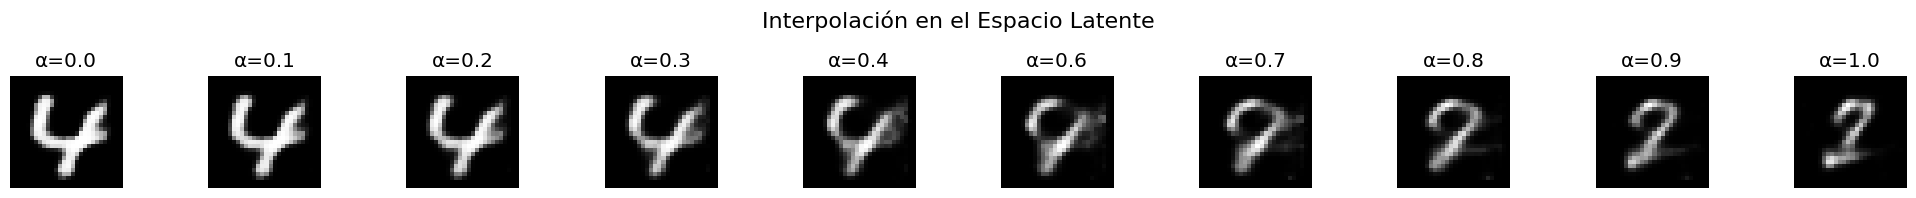


¡EXPERIMENTO COMPLETADO EXITOSAMENTE!

Resumen de lo aprendido:
1. El VAE aprendió a comprimir imágenes de MNIST en un espacio latente de 20 dimensiones
2. Puede reconstruir imágenes con buena calidad
3. El espacio latente es continuo y permite generar nuevas imágenes
4. La interpolación en el espacio latente produce transiciones suaves

Aplicaciones potenciales:
- Generación de imágenes de dígitos
- Compresión de datos
- Análisis de representaciones latentes
- Transferencia de estilo en imágenes


In [16]:
if __name__ == "__main__":
    main()